# Representative microscopy images of the cell nucleus.

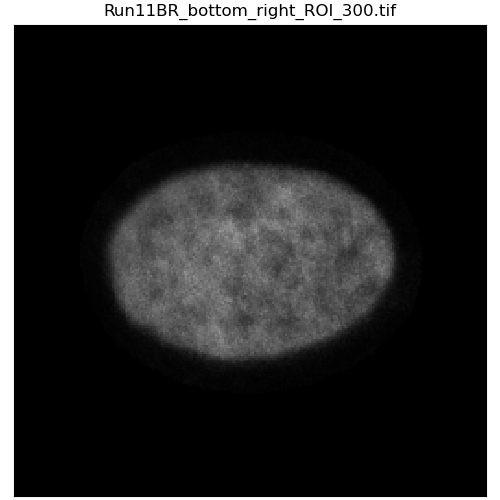

In [1]:
#| label: ae1m-practical

# ── Config ───────────────────────────────────────────────────────────────
HF_REPO = "RussellBarkley/representative_nuclei"  # datasets repo name
HF_ROOT = f"hf://datasets/{HF_REPO}"

# ── Imports & backend ───────────────────────────────────────────────────
try:
    get_ipython().run_line_magic("matplotlib", "widget")
except Exception:
    pass

import os, re
from io import BytesIO
from functools import lru_cache
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as W
import fsspec
from tifffile import imread as tiff_imread

# ── Constants ────────────────────────────────────────────────────────────
CENTERS = ["mean", "median", "geomedian"]
METRICS = ["euclidean", "cosine"]
EXTS    = (".tif", ".tiff", ".png")
rank_pat = re.compile(r"^(\d{1,4})__")  # e.g., '001__...tif'

# ── Filesystem (quiet—no prints) ────────────────────────────────────────
fs = fsspec.filesystem("hf")

def _natural_sort_key(path: str):
    base = os.path.basename(path)
    m = rank_pat.match(base)
    if m:
        try:
            return (0, int(m.group(1)), base.lower())
        except Exception:
            pass
    return (1, base.lower())

def list_ranked_images(center: str, metric: str) -> List[str]:
    """List and rank-sort up to 100 files under <HF_ROOT>/<center>/<metric>/ (quiet)"""
    folder = f"{HF_ROOT}/{center}/{metric}"
    try:
        files = fs.glob(f"{folder}/*")
    except FileNotFoundError:
        files = []
    files = [p for p in files if os.path.splitext(p)[1].lower() in EXTS]
    files.sort(key=_natural_sort_key)
    return files[:100]

# Build the index used by the viewer code (quiet)
repo_index = {(c, m): list_ranked_images(c, m) for c in CENTERS for m in METRICS}

# ── Loader with small cache ─────────────────────────────────────────────
@lru_cache(maxsize=64)
def load_image_bytes(hf_path: str) -> np.ndarray:
    """Read image from HF as grayscale float32 0..255."""
    with fs.open(hf_path, "rb") as f:
        data = f.read()
    arr = tiff_imread(BytesIO(data))

    if arr.ndim > 2:
        arr = arr[..., 0]
    arr = np.asarray(arr)

    if np.issubdtype(arr.dtype, np.floating):
        a = arr.astype(np.float32)
        if a.max() <= 1.0 + 1e-6:
            a *= 255.0
    else:
        a = arr.astype(np.float32)

    a = np.clip(a, 0, 255)
    return a

# ── Helper to trim "NNN__" prefix from titles ───────────────────────────
def _display_name(path: str) -> str:
    b = os.path.basename(path)
    return b[5:] if len(b) > 5 else b  # remove first 5 chars like '001__'

# ── UI widgets (renamed + wider spacing) ────────────────────────────────
CENTERS = ["mean", "median", "geomedian"]
METRICS = ["euclidean", "cosine"]

w_metric = W.ToggleButtons(
    options=METRICS, value="euclidean",
    description="Distance metric:", button_style="",
    layout=W.Layout(width="auto")
)
w_center = W.ToggleButtons(
    options=CENTERS, value="mean",
    description="Measure of central tendency:", button_style="",
    layout=W.Layout(width="auto")
)

# Rank control with Prev/Next buttons
w_prev = W.Button(description="◀ Prev", layout=W.Layout(width="80px"))
w_next = W.Button(description="Next ▶", layout=W.Layout(width="80px"))
w_rank = W.IntSlider(
    value=1, min=1, max=100, step=1, description="Rank:", readout=False,
    continuous_update=True, layout=W.Layout(width="320px"))
w_rank_label = W.Label(f"{w_rank.value}/100", layout=W.Layout(width="60px"))
rank_row = W.HBox([w_prev, w_rank, w_rank_label, w_next],
                   layout=W.Layout(align_items="center", gap="8px"))

# Intensity range
w_rng = W.IntRangeSlider(
    value=[0, 255], min=0, max=255, step=1, description="Intensity:",
    readout=False, continuous_update=True, layout=W.Layout(width="480px"))
w_rng_label = W.Label(f"{w_rng.value[0]} – {w_rng.value[1]}")

# Put metric and center side-by-side with extra gap
row1 = W.HBox([w_metric, w_center],
              layout=W.Layout(justify_content="flex-start", gap="28px"))
row2 = rank_row
row3 = W.HBox([w_rng, w_rng_label], layout=W.Layout(align_items="center", gap="8px"))

ui = W.VBox([row1, row2, row3], layout=W.Layout(gap="10px"))
display(ui)

# ── Figure (title shows filename without numeric prefix) ────────────────
fig, ax = plt.subplots(figsize=(5.0, 5.0), constrained_layout=True)
im = ax.imshow(np.zeros((10,10), dtype=np.float32), cmap="gray",
               vmin=0, vmax=255, interpolation="nearest")
ax.set_xticks([]); ax.set_yticks([])
title = ax.set_title("", fontsize=12)

def _current_files():
    return repo_index.get((w_center.value, w_metric.value), [])

def _clamp_rank(n):
    files = _current_files()
    if not files:
        return 1
    return int(np.clip(n, 1, len(files)))

def update_image(*_):
    files = _current_files()
    if not files:
        im.set_data(np.zeros((10,10), dtype=np.float32))
        title.set_text("")  # no filename if missing
        fig.canvas.draw_idle()
        return

    w_rank.value = _clamp_rank(w_rank.value)
    idx = w_rank.value - 1
    path = files[idx]
    arr = load_image_bytes(path)

    vmin, vmax = w_rng.value
    im.set_data(arr)
    im.set_clim(vmin=float(vmin), vmax=float(vmax))

    # trimmed filename (remove first 5 chars like '001__')
    title.set_text(_display_name(path))
    fig.canvas.draw_idle()

def on_intensity_change(change):
    vmin, vmax = change["new"]
    if vmax <= vmin:
        return
    w_rng_label.value = f"{vmin} – {vmax}"
    im.set_clim(vmin=float(vmin), vmax=float(vmax))
    fig.canvas.draw_idle()

def on_rank_change(change):
    w_rank.value = _clamp_rank(change["new"])
    files = _current_files()
    total = len(files) if files else 100
    w_rank_label.value = f"{w_rank.value}/{total}"
    update_image()

def on_prev_clicked(_):
    w_rank.value = _clamp_rank(w_rank.value - 1)

def on_next_clicked(_):
    w_rank.value = _clamp_rank(w_rank.value + 1)

# ── Bind toolbar arrows (Back/Forward) and keyboard arrows ──────────────
def _bind_toolbar_arrows(fig):
    tb = getattr(fig.canvas, "toolbar", None)
    if tb is None:
        return
    try:
        # Monkey-patch toolbar navigation to use our index navigation
        tb.back = lambda *a, **k: on_prev_clicked(None)
        tb.forward = lambda *a, **k: on_next_clicked(None)
    except Exception:
        pass

def _on_key(event):
    if event.key in ("left", "a"):
        on_prev_clicked(None)
    elif event.key in ("right", "d"):
        on_next_clicked(None)

# wire events
w_metric.observe(update_image, names="value")
w_center.observe(update_image, names="value")
w_rank.observe(on_rank_change, names="value")
w_rng.observe(on_intensity_change, names="value")
w_prev.on_click(on_prev_clicked)
w_next.on_click(on_next_clicked)

# Activate toolbar + keyboard hooks
fig.canvas.mpl_connect("key_press_event", _on_key)
_bind_toolbar_arrows(fig)

update_image()
plt.show()
